In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
if not os.path.exists('images'):
    !pip install -qU torch_snippets


import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models

     |████████████████████████████████| 54 kB 2.8 MB/s 
     |████████████████████████████████| 58 kB 7.2 MB/s 
     |████████████████████████████████| 78 kB 8.2 MB/s 
     |████████████████████████████████| 237 kB 90.4 MB/s 
     |████████████████████████████████| 1.6 MB 85.5 MB/s 
     |████████████████████████████████| 175 kB 94.8 MB/s 
     |████████████████████████████████| 2.2 MB 60.2 MB/s 
     |████████████████████████████████| 51 kB 8.4 MB/s 


In [ ]:
da = pd.read_csv('da.csv')

In [ ]:
da[5605:5700]

,Unnamed: 0,0
5605,5605,43
5606,5606,0
5607,5607,0
5608,5608,18
5609,5609,0
...,...,...
5695,5695,0
5696,5696,0
5697,5697,0
5698,5698,3


In [ ]:
!ps -aux|grep python

root          36  0.2  0.0      0     0 ?        Z    20:52   0:04 [python3] <defunct>
root          37  0.0  0.3 162020 43432 ?        S    20:52   0:00 python3 /usr/local/bin/colab-fileshim.py
root          64  0.2  0.4 201508 62136 ?        Sl   20:52   0:04 /usr/bin/python3 /usr/local/bin/jupyter-notebook --ip=172.28.0.2 --port=9000 --FileContentsManager.root_dir=/ --MappingKernelManager.root_dir=/content
root          97  0.2  0.1 128216 17024 ?        Sl   20:53   0:04 /usr/bin/python3 /usr/local/lib/python3.7/dist-packages/debugpy/adapter --for-server 41817 --host 127.0.0.1 --port 23567 --server-access-token 436fe33e7ec38ed174e64651ff19aa1accd214d63d79f024599f1fcacb0dfdd6
root         380  0.0  0.0  18388  3040 ?        S    20:56   0:00 bash -c tail -n +0 -F "/root/.config/Google/DriveFS/Logs/drive_fs.txt" | python3 /opt/google/drive/drive-filter.py > "/root/.config/Google/DriveFS/Logs/timeouts.txt" 
root         383  0.0  0.0  31300  9568 ?        S    20:56   0:00 python3 /op

In [ ]:
!kill -9 652

In [ ]:
torch.cuda.is_available()

True

In [ ]:
!nvidia-smi 

Fri Nov 11 21:22:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved

In [ ]:
f

0

In [ ]:
print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
print("torch.cuda.memory_reserved: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))

torch.cuda.memory_allocated: 0.000000GB
torch.cuda.memory_reserved: 0.000000GB
torch.cuda.max_memory_reserved: 0.000000GB


In [3]:
os.chdir('/content/drive/MyDrive/Zindi')
from torch_snippets import*

#Download Training and bounding box xdata

In [ ]:
train = pd.read_csv('Train (1).csv')
train.head(20)

In [ ]:
train_ = train.dropna()

In [ ]:
train_ = train_.reset_index(drop=True)

In [ ]:
train_.drop(['worm_type', 'number_of_worms'], axis=1, inplace=True)

In [ ]:
train_.shape

In [ ]:
bbs = pd.read_csv('images_bboxes (1).csv')
bbs.head()

,image_id,worm_type,geometry
0,id_8ada71185e18dc8838b4925b.jpg,pbw,"POLYGON ((2478.89 156.77, 2478.89 297.86, 2377..."
1,id_8ada71185e18dc8838b4925b.jpg,pbw,"POLYGON ((939.8199999999999 1221.46, 939.81999..."
2,id_8ada71185e18dc8838b4925b.jpg,abw,"POLYGON ((1559.7 1558.06, 1559.7 1966.3, 1129...."
3,id_bc86d3cfd0c0463fa5cae33e.jpg,abw,POLYGON ((2090.216399557101 1537.2100674812148...
4,id_bc86d3cfd0c0463fa5cae33e.jpg,abw,POLYGON ((2342.2568587778546 1676.304250464547...


In [ ]:
bbs = bbs.dropna()

#Refactoring geometry column. And select Xmin, Ymin, Xmax and Ymax from list

In [ ]:
def clean_bbs(x):
    x = x.replace(" ", ",")
    x = x[10:-2]
    x = x.split(',')
    return [float(xs) for xs in x if xs != '' ]

In [ ]:
bbs['geometry'] = bbs['geometry'].apply(lambda x: clean_bbs(x) if (pd.notnull(x)) else x)

In [ ]:
bbs_2 = pd.DataFrame(bbs['geometry'].to_list())

In [ ]:
bbs = bbs.reset_index()

In [ ]:
bbs_t = pd.concat([bbs, bbs_2], axis = 1)

In [ ]:
bbs_t = bbs_t.drop(columns = ['index', 'geometry'])

In [ ]:
bbs_t.head()

In [ ]:
data  = bbs_t[['image_id', 'worm_type', 4, 1, 0, 3]]

In [ ]:
data = data.rename(columns={4: 'Xmin', 1: 'Ymin', 0: 'Xmax', 3: 'Ymax'})

In [ ]:
data.to_csv('data.csv')

#Download data.csv

In [4]:
data = pd.read_csv('data.csv')

In [5]:
data.isna().sum()

Unnamed: 0    0
image_id      0
worm_type     0
Xmin          0
Ymin          0
Xmax          0
Ymax          0
dtype: int64

In [6]:
del data['Unnamed: 0']

In [ ]:
data

In [8]:
path = os.getcwd()

#Label Encoding

In [9]:
label2target = {l:t+1 for t,l in enumerate(data['worm_type'].unique())}
label2target['background'] = 0
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)

In [10]:
target2label

{1: 'pbw', 2: 'abw', 0: 'background'}

#Process img

In [ ]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)
    img[thresh == 0] = 0
    img[thresh == 255] = 255
    img = cv2.resize(img, (800,800), interpolation = cv2.INTER_LINEAR)/255.
    img = torch.tensor(img).permute(2,0,1)
    return img.to(device).float()

In [30]:
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    return img.to(device).float()

In [ ]:
x= preprocess_image(IMAGE_ROOT + '/id_8ada71185e18dc8838b4925b.jpg')

In [ ]:
x.shape

torch.Size([3, 3072, 3072])

#Function to remove boxes bigger than width/height

In [ ]:
IMAGE_ROOT =  path + '/images/'
lists = []
from tqdm import tqdm

def reform(train_, data):
    # load images and masks


      for ix in (tqdm(range(len(train_)))):
        img_path = IMAGE_ROOT + train_.image_id_worm[ix]
        data_2 = data[data['image_id'] == train_.image_id_worm[ix]]
        img = Image.open(img_path).convert("RGB")
        x,y = img.size

        data_2 = data_2[['Xmin','Xmax','Ymin','Ymax']]

        data_2[['Xmin','Xmax']] *= 1/x
        data_2[['Ymin','Ymax']] *= 1/y

        m = data_2[['Xmin','Xmax','Ymin','Ymax']].values.max(axis = 0)

        a = [m[0], m[1]]
        b = [m[2], m[3]]

        if 1 < max(a) or 1 < max(b):
          lists.append(ix)
      return lists

In [ ]:
bad_lists = reform(train_, data)

 29%|██▉       | 1899/6602 [13:25<32:46,  2.39it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
100%|██████████| 6602/6602 [46:26<00:00,  2.37it/s]


In [ ]:
datafr = pd.DataFrame(bad_lists)

datafr.to_csv('my_badlist.csv')

In [ ]:
train_.drop(bad_lists, inplace=True)

In [ ]:
train_ = train_.reset_index(drop = True)

#import training data (without NaN)

In [18]:
train_ = pd.read_csv('no_badlist.csv')

In [19]:
del train_['Unnamed: 0']

In [ ]:
train_[:30]

#Dataset Class

In [31]:
path = os.getcwd()
IMAGE_ROOT =  path + '/images'

import glob
class OpenDataset(torch.utils.data.Dataset):
    w,h = 800,800

#     tfms = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
# ])
    def __init__(self, df, bs, image_dir=IMAGE_ROOT):
    
        self.image_dir = image_dir
        self.files = glob.glob(self.image_dir+'/*')
        self.df = df
        self.bs = bs
        self.image_infos = self.df.image_id_worm.unique()
    def __getitem__(self, ix):
        # load images and masks
        image_id = self.image_infos[ix]
        img_path =  find(image_id, self.files)
        img = Image.open(img_path).convert("RGB")
        x,y = img.size
        data = self.bs[self.bs['image_id'] == image_id]
        labels = data['worm_type'].values.tolist()

        data = data[['Xmin','Ymin','Xmax','Ymax']].values

        # bb_s = pd.DataFrame(data_2['geometry'].to_list())
        data[:,[0,2]] *= self.w/x
        data[:,[1,3]] *= self.h/y
        boxes_ = data.astype(np.uint32).tolist()
        lists = []
        for ix, box in enumerate(boxes_):
          if box[0] >= box[2] or box[1] >= box[3]:
            lists.append(ix) # min x > max x or min y > max y
        boxes = np.delete(boxes_, lists, 0)

        img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR))/255.
        #add if state,=ment for values higher than 224
        #convert to integr



        
        # img = img/255.

        # data = pd.concat([bb_s.loc[:, [4]], bb_s.loc[:, [1]], bb_s.loc[:, [0]], bb_s.loc[:, [3]]], axis =1)
        # data = data.apply(pd.to_numeric)
        # boxes = data_2[['Xmin', 'Ymin', 'Xmax', 'Ymax' ]].to_numpy(dtype = np.int32) # convert to absolute coordinates
        # torch FRCNN expects ground truths as a dictionary of tensors
        target = {}
        target["boxes"] = torch.Tensor(boxes).float()
        target["labels"] = torch.Tensor([label2target[i] for i in labels]).long()
        img = preprocess_image(img)
        return img, target
            
    def collate_fn(self, batch):
        return tuple(zip(*batch)) 

    def __len__(self):
        return len(self.image_infos)

#Split train-test

In [32]:
from sklearn.model_selection import train_test_split
import glob
trn_ids, val_ids = train_test_split(train_.image_id_worm.unique(), test_size=100, random_state=99)
trn_df, val_df = train_[train_['image_id_worm'].isin(trn_ids)], train_[train_['image_id_worm'].isin(val_ids)]
print(len(trn_df), len(val_df))

train_ds = OpenDataset(trn_df,data)
test_ds = OpenDataset(val_df,data)



train_loader = DataLoader(train_ds, batch_size=10, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=10, collate_fn=test_ds.collate_fn, drop_last=True)

6499 103

In [ ]:
show(train_ds[278][0])

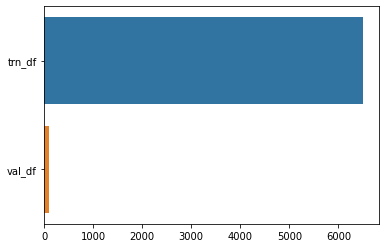

In [ ]:
import seaborn as sns
my_dict  = { 'trn_df': len(trn_df), 'val_df': len(val_df)}

keys = list(my_dict.keys())
# get values in the same order as keys, and parse percentage values
vals = [float(my_dict[k]) for k in keys]
sns.barplot(y=keys, x=vals)

#import Faster-RCNN

In [13]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_model():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
model = get_model().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001,
                            momentum=0.9, weight_decay=0.0005)
n_epochs = 2
log = Report(n_epochs)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

#Train_Test Function

In [14]:
# Defining training and validation functions for a single batch
def train_batch(inputs, model, optimizer):
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad() # this will disable gradient computation in the function below
def validate_batch(inputs, model):
    model.train() # to obtain the losses, model needs to be in train mode only. # #Note that here we are not defining the model's forward method 
#and hence need to work per the way the model class is defined
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [ ]:
ls

#Save train_test loaders

In [ ]:
torch.save(train_loader, 'Traindataloader.pth')
torch.save(test_loader, 'Testdataloader.pth')

In [ ]:
train_loader = torch.load('Traindataloader.pth')
test_loader = torch.load('Testdataloader.pth')

In [ ]:
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, losses = train_batch(inputs, model, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
            [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(), 
                   trn_regr_loss=regr_loss.item(), trn_objectness_loss=loss_objectness.item(),
                   trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        loss, losses = validate_batch(inputs, model)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
          [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss.item(), 
                  val_regr_loss=regr_loss.item(), val_objectness_loss=loss_objectness.item(),
                  val_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
    # if (epoch+1)%(n_epochs//5)==0: log.report_avgs(epoch+1)

In [ ]:
import gc
# del data
gc.collect()

100%|██████████| 103/103 [00:00<00:00, 2660.38it/s]


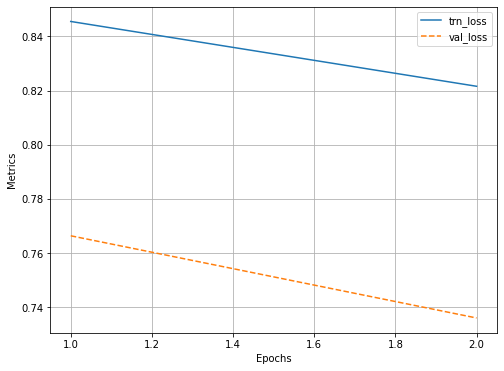

In [ ]:
log.plot_epochs(['trn_loss','val_loss'])

In [ ]:
show(train_ds[4105][0].permute(1,2,0), bbs =train_ds[4105][1]['boxes'])

In [ ]:
bbs =train_ds[4105][1]['boxes']
bbs

In [ ]:
torch.save(model.state_dict(), 'Second_Model_11_25nn.pth')

In [433]:
from torchvision.ops import nms
def decode_output(output):
    'convert tensors to numpy arrays'
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([target2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]

    if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

In [ ]:
model.eval()
for ix, (images, targets) in enumerate(test_loader):
    if ix==10: break
    images = [im for im in images]
    outputs = model(images)
    for ix, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        info = [f'{l}@{c:.2f}' for l,c in zip(labels, confs)]
        show(images[ix].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=5)

#Evaluate Model on Test_set

In [ ]:
model_light = get_model()
# model = TheModelClass(*args, **kwargs)
model_light.load_state_dict(torch.load('/content/drive/MyDrive/Zindi/Second_Model_11_23n.pth'))
if torch.cuda.is_available():
    model_light.cuda()
model_light.eval()

In [671]:
model_light.eval()


# from tqdm import tqdm
# for ix in tqdm(range(len(test))):
 
#   name = test.image_id_worm[ix]
#   img = read_testimg(name)
#   outputs = model_light(img.unsqueeze(0))
#   labels = outputs[0]['labels'].tolist()
#   count = Counter(labels)
#   a = ix * 2
#   b = ix *2 + 1

#   arr[a,0] = count[2]
#   arr[b,0] = count[1]

from tqdm import tqdm
from torchvision.ops import nms



def decode_output(output):
    bbe = []
    ls = []
    llb = []
    'convert tensors to numpy arrays'
    bbs = output[0]['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([target2label[i] for i in output[0]['labels'].cpu().detach().numpy()])
    confs = output[0]['scores'].cpu().detach().numpy()
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]
    if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]

    bbs = bbs.tolist()
    confs = confs.tolist()
    labels = labels.tolist()

    for ix in range(len(confs)):
      if confs[ix] < 0.5:
        ls.append(ix)

    for ix,item in enumerate(bbs):
      if ix not in ls:
        bbe.append(item)

    for ix,item in enumerate(labels):
      if ix not in ls:
        llb.append(item)
        

    
    return bbe, llb, confs

def read_testimg(img_path):


  img = Image.open(img_path).convert("RGB")
  img = np.array(img.resize((800, 800), resample=Image.BILINEAR))/255.
  img = preprocess_image(img)
  return img



def split_read(x):
  a = x.split('_',2)
  name = a[0] +'_'+a[1] +'.jpg'
  img = read_testimg(name)
  outputs = model_light(img.unsqueeze(0))
  bbs, confs, labels = decode_output(outputs)
  count = Counter(labels)
  if a[2] == 'pbw':
    return count['pbw']
  return count['abw']


tqdm.pandas()


In [551]:
output = model_light(im4.unsqueeze(0))
bbe = []
ls = []
llb = []
bbs = output[0]['boxes'].cpu().detach().numpy().astype(np.uint16)
labels = np.array([target2label[i] for i in output[0]['labels'].cpu().detach().numpy()])
confs = output[0]['scores'].cpu().detach().numpy()
ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]
if len(ixs) == 1:
    bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]

bbs = bbs.tolist()
confs = confs.tolist()
labels = labels.tolist()

for ix in range(len(confs)):
  if confs[ix] < 0.75:
    ls.append(ix)

for ix,item in enumerate(bbs):
  if ix not in ls:
    bbe.append(item)

for iox,items in enumerate(labels):
  if iox not in ls:
    llb.append(items)
        

In [ ]:
llb

In [522]:
ls

SyntaxError: ignored

In [523]:
bbe = []
for ix,item in enumerate(bbs):
  if ix not in ls:
    bbe.append(item)

In [527]:
a,b,c = decode_output(model_light(img.unsqueeze(0)))

In [528]:
a

[[434, 297, 534, 424],
 [295, 321, 388, 427],
 [423, 692, 515, 800],
 [387, 619, 474, 697],
 [398, 169, 489, 239]]

In [ ]:
show(img.permute(1,2,0), bbs = a)

In [ ]:
show(train_ds[4105][0])

In [ ]:
train_ds[4105][0].shape

In [683]:
import glob
submision = pd.read_csv('/content/drive/MyDrive/Zindi/SampleSubmission.csv')
files = glob.glob(IMAGE_ROOT +'/*')
ls = []


for ix in tqdm(range(len(submision))) :
  img_name = submision.image_id_worm[ix]
  a = img_name.split('_',2)
  name = a[0] +'_'+a[1] +'.jpg'

  img_path =  find(name, files)

  if img_path == None: 
    ls.append(0)
  else:
    img = read_testimg(img_path)
    outputs = model_light(img.unsqueeze(0))
    bbs, labels, conf = decode_output(outputs)
    count = Counter(labels)
    if a[2] == 'pbw':
      ls.append(count['pbw'])
    elif a[2] =='abw':
      ls.append(count['abw'])

100%|██████████| 5606/5606 [40:51<00:00,  2.29it/s]


In [ ]:
ls

In [648]:
import glob
submision = pd.read_csv('/content/drive/MyDrive/Zindi/SampleSubmission.csv')
files = glob.glob(IMAGE_ROOT +'/*')
ls = []
total_ls = []
left = [10,400]
top = [10, 400]


for ix in tqdm(range(len(submision))) :
  img_name = submision.image_id_worm[ix]

  a = img_name.split('_',2)
  name = a[0] +'_'+a[1] +'.jpg'

  img_path =  find(name, files)

  if img_path == None: 
    ls.append(0)
  else:

    img = read_testimg(img_path)
    im1 = torchvision.transforms.functional.crop( img, top[0], left[0], 400, 400)
    im2 = torchvision.transforms.functional.crop( img, top[0], left[1], 400, 400)
    im3 = torchvision.transforms.functional.crop( img, top[1], left[0], 400, 400)
    im4 = torchvision.transforms.functional.crop( img, top[1], left[1], 400, 400)

    img_ls = [im1, im2,im3,im4]
    for im in range(len(img_ls)):

      outputs = model_light(img_ls[im].unsqueeze(0))
      bbs, labels, confs = decode_output(outputs)
      count = Counter(labels)
      if a[2] == 'pbw':
        ls.append(count['pbw'])
      elif a[2] =='abw':
        ls.append(count['abw'])
    total_ls.append(sum(ls))
    ls = []

100%|██████████| 5606/5606 [1:30:44<00:00,  1.03it/s]


In [655]:
len(submision)

5606

In [689]:
da = pd.DataFrame(ls)
sub = pd.concat([submision, da],axis = 1)
del sub['number_of_worms']
sub = sub.rename(columns = {0: 'number_of_worms'})
sub.to_csv('sub_11-27b.csv', index = False)

In [679]:
img_name = 'id_0087ad7987b3f82bc5b5c7d0_abw'
a = img_name.split('_',2)
name = a[0] +'_'+a[1] +'.jpg'
ls = []
img_path =  find(name, files)

if img_path == None: 
  ls.append(0)
else:

  img = read_testimg(img_path)
  im1 = torchvision.transforms.functional.crop( img, top[0], left[0], 400, 400)
  im2 = torchvision.transforms.functional.crop( img, top[0], left[1], 400, 400)
  im3 = torchvision.transforms.functional.crop( img, top[1], left[0], 400, 400)
  im4 = torchvision.transforms.functional.crop( img, top[1], left[1], 400, 400)

  img_ls = [im1, im2,im3,im4]
  for im in range(len(img_ls)):

    outputs = model_light(img_ls[im].unsqueeze(0))
    bbs, labels, confs = decode_output(outputs)
    count = Counter(labels)
    if a[2] == 'pbw':
      ls.append(count['pbw'])
    elif a[2] =='abw':
      ls.append(count['abw'])
  total_ls.append(sum(ls))

In [680]:
ls

[0, 0, 0, 0]

In [681]:
a,b,c = decode_output(model_light(im1.unsqueeze(0)))


In [ ]:
show(img)

In [ ]:
bb = decode_output(model_light(img.unsqueeze(0)))[0]
bb = torch.tensor(bb)
show(img.permute(1,2,0), bbs = bb)

In [646]:
len(bb)

18

In [ ]:
bb = decode_output(model_light(im4.unsqueeze(0)))[0]
bb = torch.tensor(bb)
show(im4.permute(1,2,0), bbs = bb)

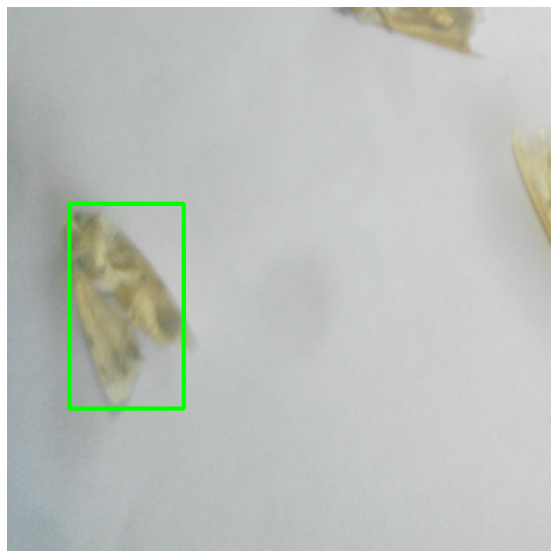

In [ ]:
from PIL import Image
!pip install ufp
import ufp.image
import PIL
# im = PIL.Image.open('test.jpg', 'r')
trimed = ufp.image.trim(img_ls[3], fuzz=13.3)
trimed.save('trimed.jpg')

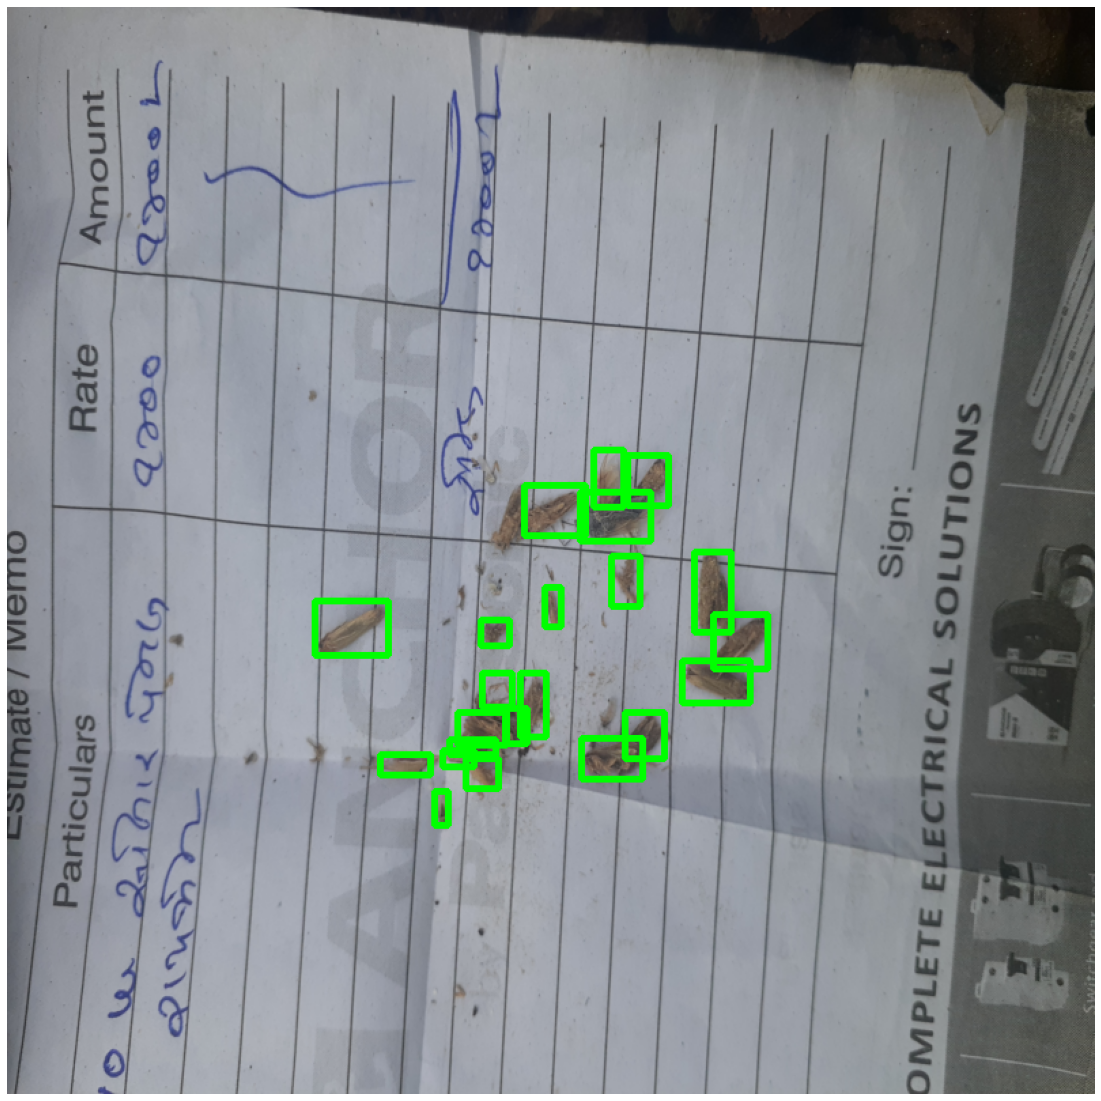

In [139]:
show(img.permute(1,2,0), bbs = bb)

#Retrain Model

In [ ]:


model_light = get_model()
# model = TheModelClass(*args, **kwargs)
model_light.load_state_dict(torch.load('/content/drive/MyDrive/Zindi/Second_Model_11_17.pth'))
if torch.cuda.is_available():
    model_light.cuda()
model_light.eval()

In [ ]:
def train_batch(inputs, model_light, optimizer):
    model_light.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model_light(input, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad() # this will disable gradient computation in the function below
def validate_batch(inputs, model_light):
    model_light.train() # to obtain the losses, model_light needs to be in train mode only. # #Note that here we are not defining the model_light's forward method 
#and hence need to work per the way the model_light class is defined
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()
    losses = model_light(input, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [691]:
optimizer = torch.optim.SGD(model_light.parameters(), lr=0.0001,
                            momentum=0.9, weight_decay=0.0005)
n_epochs = 5
log = Report(n_epochs)

In [ ]:
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, losses = train_batch(inputs, model_light, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
            [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(), 
                   trn_regr_loss=regr_loss.item(), trn_objectness_loss=loss_objectness.item(),
                   trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        loss, losses = validate_batch(inputs, model_light)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
          [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss.item(), 
                  val_regr_loss=regr_loss.item(), val_objectness_loss=loss_objectness.item(),
                  val_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
    # if (epoch+1)%(n_epochs//5)==0: log.report_avgs(epoch+1)

EPOCH: 1.834  trn_loss: 0.700  trn_loc_loss: 0.184  trn_regr_loss: 0.413  trn_objectness_loss: 0.030  trn_rpn_box_reg_loss: 0.074  (5093.47s - 8791.83s remaining)

In [ ]:
torch.save(model_light.state_dict(), 'Second_Model_11_27n.pth')